In [11]:
! pip install torch scikit-learn matplotlib seaborn numpy pennylane umap-learn joblib

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pennylane as qml
import joblib
import pandas as pd
import os

In [13]:
# ---------------------- LOAD LABELS ----------------------
labels_df = pd.read_csv(r"C:\Users\muthu\OneDrive\Desktop\SLEEP POSTURE\experiment-ii_labels.csv")
base_dir = "experiment-ii"
file_paths, unique_labels = [], []
for _, row in labels_df.iterrows():
    full_path = os.path.join(base_dir, row["Subject"], row["Mat_Type"], row["File_Name"])
    if os.path.exists(full_path):
        file_paths.append(full_path)
        unique_labels.append(row["Label"])
label_mapping = {label: idx for idx, label in enumerate(sorted(set(unique_labels)))}
labels = [label_mapping[lbl] for lbl in unique_labels]
# ---------------------- LOAD MATRIX FILES FROM .TXT ----------------------
X = []
for path in file_paths:
    try:
        matrix = np.loadtxt(path)  # Assumes whitespace- or tab-delimited .txt files
        X.append(matrix.flatten())  # Flatten 2D matrix to 1D
    except Exception as e:
        print(f"Failed to load {path}: {e}")
X = np.array(X)
Y = np.array(labels)

In [14]:
minmax=MinMaxScaler()
X_scaled=minmax.fit_transform(X)

pca = PCA(n_components=11)
data_pca = pca.fit_transform(X_scaled)
joblib.dump(pca, "pca6_model.pkl")
print("✅ PCA model saved.")

✅ PCA model saved.


In [15]:
X_tensor = torch.tensor(data_pca, dtype=torch.float32)
y_tensor = torch.tensor(Y, dtype=torch.long)  # Use long for classification

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, stratify=y_tensor, random_state=42
)

print("✅ Train and test sets prepared.")
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

✅ Train and test sets prepared.
Train size: torch.Size([372, 11]), Test size: torch.Size([93, 11])


In [16]:
# Define device once
num_qubits = 11
state_vector_length = 2 ** num_qubits

dev = qml.device("default.qubit", wires=num_qubits)

# Quantum Convolution Layer
def QuantumConvLayer(x, weights):
    batch_size = x.shape[0]

    @qml.qnode(dev, interface="torch")
    def circuit(x_, w):
        padded_x = torch.nn.functional.pad(x_, (0, state_vector_length - x_.shape[0]), mode='constant', value=0)
        qml.AmplitudeEmbedding(padded_x, wires=range(num_qubits), normalize=True)
        for l in range(w.shape[0]):
            for i in range(num_qubits):
                qml.RY(w[l, i, 0], wires=i)
                qml.RZ(w[l, i, 1], wires=i)
            for i in range(num_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            qml.CNOT(wires=[num_qubits - 1, 0])
        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    stacked_results = [torch.stack(circuit(x[i], weights)).float() for i in range(batch_size)]
    return torch.stack(stacked_results)

# Quantum Pooling Layer
def QuantumPoolingLayer(x):
    batch_size = x.shape[0]

    @qml.qnode(dev, interface="torch")
    def circuit(x_):
        padded_x = torch.nn.functional.pad(x_, (0, state_vector_length - x_.shape[0]), mode='constant', value=0)
        qml.AmplitudeEmbedding(padded_x, wires=range(num_qubits), normalize=True)
        for i in range(0, num_qubits - 1, 2):
            qml.CRY(np.pi / 2, wires=[i, i + 1])
        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    stacked_results = [torch.stack(circuit(x[i])).float() for i in range(batch_size)]
    return torch.stack(stacked_results)

# Quantum Convolutional Neural Network
class QCNN(nn.Module):
    def __init__(self, num_qubits=11, num_layers=3, num_classes=3):
        super(QCNN, self).__init__()
        self.num_qubits = num_qubits
        self.num_layers = num_layers

        self.q_params1 = nn.Parameter(0.01 * torch.randn(num_layers, num_qubits, 2))
        self.q_params2 = nn.Parameter(0.01 * torch.randn(num_layers, num_qubits, 2))

        self.fc1 = nn.Linear(num_qubits, 128)
        self.norm1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x, return_quantum_features=False):
        if isinstance(x, list):
            x = torch.stack(x)
        elif isinstance(x, torch.Tensor):
            x = x.float()

        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        x = QuantumConvLayer(x, self.q_params1)
        x = QuantumPoolingLayer(x)
        x = QuantumConvLayer(x, self.q_params2)
        x = QuantumPoolingLayer(x)

        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.norm1(x)
        x = self.fc2(x)

        return x


In [17]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader for training and testing
batch_size = 32  # You can adjust this based on your system's memory and requirements

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Train loader created with batch size {batch_size}.")
print(f"✅ Test loader created with batch size {batch_size}.")

# Number of samples in the training and test datasets
num_train_samples = len(train_loader.dataset)  # Correct way to get the number of samples
num_test_samples = len(test_loader.dataset)

print(f"Number of training samples: {num_train_samples}")
print(f"Number of testing samples: {num_test_samples}")

✅ Train loader created with batch size 32.
✅ Test loader created with batch size 32.
Number of training samples: 372
Number of testing samples: 93


In [18]:
num_classes = len(np.unique(y_train))
num_qubits = 11

model = QCNN(num_qubits=num_qubits, num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Print model and device info
print(f"✅ Model initialized with {num_classes} classes.")
print(f"✅ Using device: {device}")

✅ Model initialized with 4 classes.
✅ Using device: cpu


In [ ]:
# Trackers
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

n_epochs = 40

for epoch in range(n_epochs):
    # ---------- TRAINING ----------
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        # Ensure the inputs are tensors (in case they are lists)
        # Ensure inputs are torch tensors
        # Ensure inputs is in the correct format (list of lists or numpy array)
        
        inputs = inputs.to(torch.float32)


        if len(inputs.shape) == 1:  # If it's a 1D tensor, add a batch dimension
            inputs = inputs.unsqueeze(0)

        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Ensure the inputs are tensors (in case they are lists)
            
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / total_val
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # ---------- LOG ----------
    print(f"Epoch [{epoch+1}/{n_epochs}]")
    print(f"  Train    -> Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy*100:.2f}%")
    print(f"  Validate -> Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy*100:.2f}%\n")



Epoch [1/40]
  Train    -> Loss: 1.2577, Accuracy: 38.71%
  Validate -> Loss: 1.2549, Accuracy: 40.86%

Epoch [2/40]
  Train    -> Loss: 1.2634, Accuracy: 39.78%
  Validate -> Loss: 1.2547, Accuracy: 39.78%

Epoch [3/40]
  Train    -> Loss: 1.2548, Accuracy: 38.98%
  Validate -> Loss: 1.2533, Accuracy: 40.86%

Epoch [4/40]
  Train    -> Loss: 1.2603, Accuracy: 40.05%
  Validate -> Loss: 1.2566, Accuracy: 40.86%

Epoch [5/40]
  Train    -> Loss: 1.2646, Accuracy: 39.78%
  Validate -> Loss: 1.2541, Accuracy: 40.86%

Epoch [6/40]
  Train    -> Loss: 1.2571, Accuracy: 38.17%
  Validate -> Loss: 1.2559, Accuracy: 39.78%

Epoch [7/40]
  Train    -> Loss: 1.2586, Accuracy: 39.78%
  Validate -> Loss: 1.2594, Accuracy: 43.01%

Epoch [8/40]
  Train    -> Loss: 1.2620, Accuracy: 39.25%
  Validate -> Loss: 1.2528, Accuracy: 40.86%

Epoch [9/40]
  Train    -> Loss: 1.2574, Accuracy: 38.98%
  Validate -> Loss: 1.2538, Accuracy: 41.94%

Epoch [10/40]
  Train    -> Loss: 1.2489, Accuracy: 39.25%
  Val

In [36]:
import torch
import numpy as np

# Make sure model, train_loader, test_loader, criterion are defined already!

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

# Trackers
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

n_epochs = 40
best_val_accuracy = 0

for epoch in range(n_epochs):
    model.train()
    train_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs = inputs.to(torch.float32).to(device)
        labels = labels.to(device)

        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 🔥 Gradient Clipping
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / total_train
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # ---------- VALIDATION ----------
    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(torch.float32).to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / total_val
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()  # 🔁 Adjust LR

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")

    # LOGS
    print(f"Epoch [{epoch+1}/{n_epochs}]")
    print(f"  🏋️‍♂️ Train    -> Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy*100:.2f}%")
    print(f"  ✅ Validate -> Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy*100:.2f}%\n")

# Optionally load best model:
# model.load_state_dict(torch.load("best_model.pth"))


Epoch [1/40]
  🏋️‍♂️ Train    -> Loss: 1.1453, Accuracy: 46.51%
  ✅ Validate -> Loss: 1.3077, Accuracy: 37.63%

Epoch [2/40]
  🏋️‍♂️ Train    -> Loss: 1.1616, Accuracy: 47.04%
  ✅ Validate -> Loss: 1.3017, Accuracy: 38.71%

Epoch [3/40]
  🏋️‍♂️ Train    -> Loss: 1.1341, Accuracy: 48.66%
  ✅ Validate -> Loss: 1.3025, Accuracy: 40.86%

Epoch [4/40]
  🏋️‍♂️ Train    -> Loss: 1.1347, Accuracy: 49.73%
  ✅ Validate -> Loss: 1.3166, Accuracy: 38.71%

Epoch [5/40]
  🏋️‍♂️ Train    -> Loss: 1.1159, Accuracy: 50.00%
  ✅ Validate -> Loss: 1.2955, Accuracy: 38.71%

Epoch [6/40]
  🏋️‍♂️ Train    -> Loss: 1.1170, Accuracy: 51.61%
  ✅ Validate -> Loss: 1.3084, Accuracy: 38.71%

Epoch [7/40]
  🏋️‍♂️ Train    -> Loss: 1.1115, Accuracy: 52.15%
  ✅ Validate -> Loss: 1.3032, Accuracy: 37.63%

Epoch [8/40]
  🏋️‍♂️ Train    -> Loss: 1.1071, Accuracy: 52.42%
  ✅ Validate -> Loss: 1.3230, Accuracy: 34.41%

Epoch [9/40]
  🏋️‍♂️ Train    -> Loss: 1.1235, Accuracy: 48.92%
  ✅ Validate -> Loss: 1.3258, Accuracy: 

In [31]:
# ---------- TESTING ----------
model.eval()  # Ensure model is in evaluation mode
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():  # Disable gradient tracking during testing
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)  # Accumulate loss

        # Get predicted class labels
        predicted = torch.argmax(outputs, dim=1)  # More explicit prediction

        # Count correct predictions
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

# Calculate average loss and accuracy
avg_test_loss = test_loss / total_test
test_accuracy = correct_test / total_test

# Final test results
print("---------- FINAL TEST RESULTS ----------")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


---------- FINAL TEST RESULTS ----------
Test Loss: 1.2549
Test Accuracy: 33.33%


In [32]:
# Assume `model` is your trained QCNN instance
torch.save(model.state_dict(), "qcnn6_model.pth")
print("✅ Trained QCNN model  saved as 'qcnn6_model.pth'")

✅ Trained QCNN model  saved as 'qcnn6_model.pth'


In [33]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='x')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='x')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


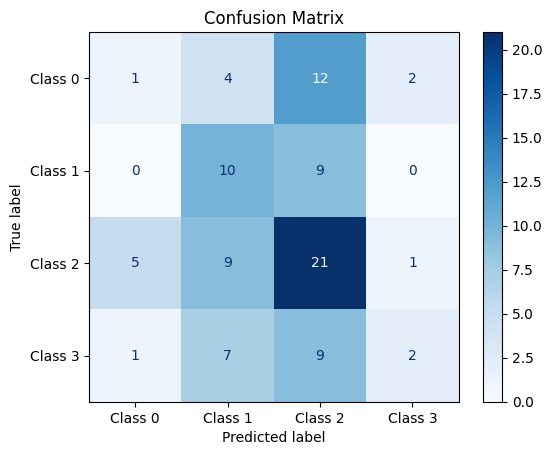

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.14      0.05      0.08        19
     Class 1       0.33      0.53      0.41        19
     Class 2       0.41      0.58      0.48        36
     Class 3       0.40      0.11      0.17        19

    accuracy                           0.37        93
   macro avg       0.32      0.32      0.28        93
weighted avg       0.34      0.37      0.32        93



In [38]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Gather all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Automatically determine number of classes
num_classes = len(np.unique(all_labels))
class_names = [f"Class {i}" for i in range(num_classes)]

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
